In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples = 4000, n_features = 2, n_informative = 2, 
                                                                          n_classes = 2, n_redundant = 0, flip_y = 0.04, 
                                                                          n_clusters_per_class = 1, random_state = 5)

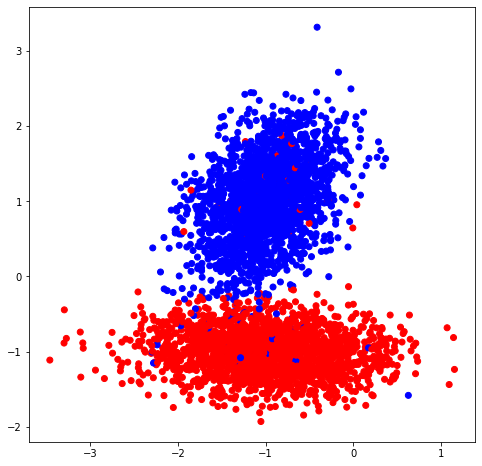

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        #self.tree_deep = tree_deep
        #tree_depth = max(tree_depth, tree_deep)
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [6]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчёт критерия энтропии Шеннона

def entropy(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** np.log2(p)
                   
    return impurity

In [8]:
# Реализуем функцию выбора критерия

def criterion_choice(labels, criterion):
    if criterion == 'gini':
        return gini(labels)
    elif criterion == 'entropy':
        return entropy(labels)
    else:
        raise Exception('Критерий не выбран')

In [9]:
# Расчёт качества

def quality(left_labels, right_labels, current_criterion, criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criterion - p * criterion_choice(left_labels, criterion) - (1 - p) * criterion_choice(right_labels, criterion)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criterion):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_criterion = criterion_choice(labels, criterion)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# Разобьём выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                    classification_labels, 
                                                                                    test_size = 0.3,
                                                                                    random_state = 1)

#### Джини

In [15]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth, criterion = 'gini'):
    
    depth = max_depth 
    
    while depth != 0:
    
        quality, t, index = find_best_split(data, labels, criterion)

        # Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        # Добавим критерий остановы по глубине дерева
        if depth == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, max_depth)
        false_branch = build_tree(false_data, false_labels, max_depth)
        
        depth -= 1

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [16]:
# Построим дерево по обучающей выборке
my_tree_gini = build_tree(train_data, train_labels, max_depth = 1, criterion = 'gini')

In [17]:
# Напечатаем ход нашего дерева

def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree_gini)

Индекс 1
Порог -0.308318640306368
--> True:
  Индекс 1
  Порог -0.5567887833083254
  --> True:
    Индекс 1
    Порог -1.0329838069640283
    --> True:
      Индекс 0
      Порог -1.2856434663150378
      --> True:
        Индекс 0
        Порог -1.3237549956837316
        --> True:
          Прогноз: 0
        --> False:
          Индекс 1
          Порог -1.2048107847000833
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 1
      Порог -1.0281507837509813
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -2.2351652986007537
        --> True:
          Индекс 0
          Порог -2.295023425403416
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 0
        --> False:
          Индекс 1
          Порог -0.7003122860000887
          --> True:
            Индекс 1
            Порог -0.8126251210043086
            --> True:

In [18]:
# Получим ответы для обучающей выборки

train_answers = predict(train_data, my_tree_gini)

In [19]:
# И получим ответы для тестовой выборки

answers = predict(test_data, my_tree_gini)

In [20]:
# Введем функцию подсчёта точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [21]:
# Точность на обучающей выборке

train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.89285714285715

In [22]:
# Точность на тестовой выборке

test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

97.83333333333334

Text(0.5, 1.0, 'Test accuracy=97.83')

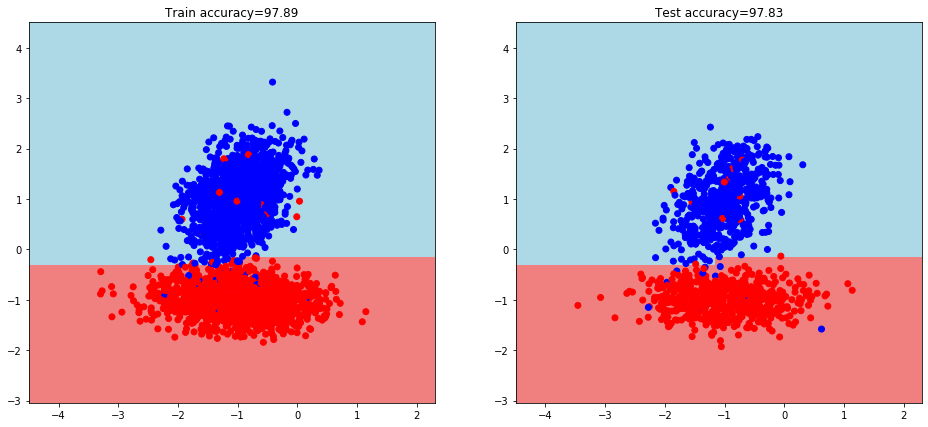

In [23]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_gini)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

#### Энтропия Шеннона

In [24]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth, criterion = 'entropy'):
    
    depth = max_depth 
    
    while depth != 0:
    
        quality, t, index = find_best_split(data, labels, criterion)

        # Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        # Добавим критерий остановы по глубине дерева
        if depth == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, max_depth)
        false_branch = build_tree(false_data, false_labels, max_depth)
        
        depth -= 1

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [25]:
# Построим дерево по обучающей выборке
my_tree_entropy = build_tree(train_data, train_labels, max_depth = 1, criterion = 'entropy')

In [26]:
# Напечатаем ход нашего дерева

def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree_entropy)

Индекс 1
Порог -1.0814978643390543
--> True:
  Прогноз: 0
--> False:
  Индекс 1
  Порог 1.7961466575398535
  --> True:
    Индекс 1
    Порог -1.0329838069640283
    --> True:
      Прогноз: 0
    --> False:
      Индекс 1
      Порог 1.5205763505697634
      --> True:
        Индекс 1
        Порог -0.16674917447110504
        --> True:
          Индекс 0
          Порог -0.5632649578101125
          --> True:
            Индекс 1
            Порог -0.7002711025535655
            --> True:
              Индекс 1
              Порог -0.8294537406358584
              --> True:
                Индекс 0
                Порог -0.9888271666274875
                --> True:
                  Индекс 1
                  Порог -0.9101107935421546
                  --> True:
                    Индекс 1
                    Порог -0.9877052975625827
                    --> True:
                      Индекс 0
                      Порог -1.2172617791889127
                      --> True:
         

In [27]:
# Получим ответы для обучающей выборки

train_answers = predict(train_data, my_tree_entropy)

In [28]:
# И получим ответы для тестовой выборки

answers = predict(test_data, my_tree_entropy)

In [29]:
# Введем функцию подсчёта точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [30]:
# Точность на обучающей выборке

train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.92857142857143

In [31]:
# Точность на тестовой выборке

test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

97.83333333333334

Text(0.5, 1.0, 'Test accuracy=97.83')

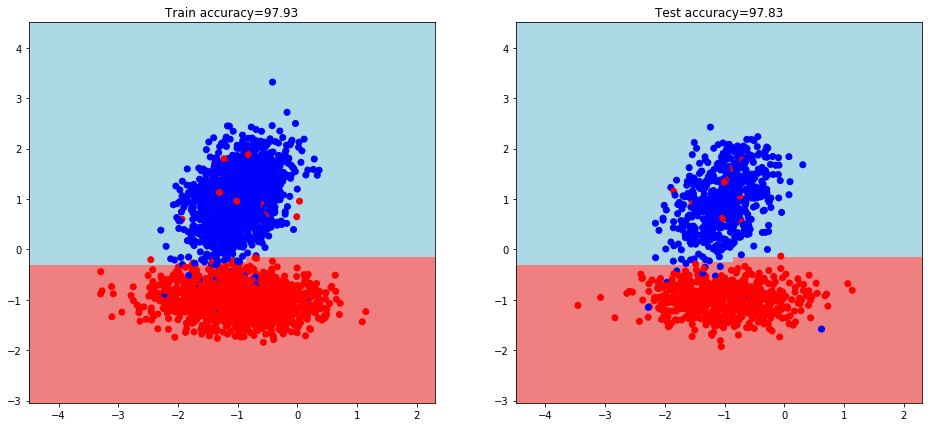

In [32]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_entropy)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

На тренировочных данных энтропия Шеннона показывается себя немного лучше, чем Джини (97.93 против 97.89), но на тестовых разницы нет (97.83).